# 该作业基于课程发布的作业样例修改而成，感谢老师和助教的辛勤付出！

 # **Homework 15 - Reinforcement Learning**

若有任何問題，歡迎來信至助教信箱 ntu-ml-2020spring-ta@googlegroups.com



## 前置作業

首先我們需要安裝必要的系統套件及 PyPi 套件。
gym 這個套件由 OpenAI 所提供，是一套用來開發與比較 Reinforcement Learning 演算法的工具包（toolkit）。
而其餘套件則是為了在 Notebook 中繪圖所需要的套件。

In [2]:
!apt update
!apt install python-opengl xvfb -y
!pip install gym[box2d] pyvirtualdisplay tqdm

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:8 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [76.0 kB]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:13 https://developer.download.nvi

接下來，設置好 virtual display，並引入所有必要的套件。

In [3]:
%%capture
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

%matplotlib inline
import matplotlib.pyplot as plt

from IPython import display

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm.notebook import tqdm

from collections import namedtuple, deque
import random

最後，引入 OpenAI 的 gym，並建立一個 [Lunar Lander](https://gym.openai.com/envs/LunarLander-v2/) 環境。

In [11]:
%%capture
import gym
env = gym.make('LunarLander-v2')

## 什麼是 Lunar Lander？

“LunarLander-v2” 這個環境是在模擬登月小艇降落在月球表面時的情形。
這個任務的目標是讓登月小艇「安全地」降落在兩個黃色旗幟間的平地上。
> Landing pad is always at coordinates (0,0).
> Coordinates are the first two numbers in state vector.

![](https://gym.openai.com/assets/docs/aeloop-138c89d44114492fd02822303e6b4b07213010bb14ca5856d2d49d6b62d88e53.svg)

所謂的「環境」其實同時包括了 agent 和 environment。
我們利用 `step()` 這個函式讓 agent 行動，而後函式便會回傳 environment 給予的 observation/state（以下這兩個名詞代表同樣的意思）和 reward。

### Observation / State

首先，我們可以看看 environment 回傳給 agent 的 observation 究竟是長什麼樣子的資料：

In [ ]:
print(env.observation_space)

Box(-inf, inf, (8,), float32)


`Box(8,)` 說明我們會拿到 8 維的向量作為 observation，其中包含：垂直及水平座標、速度、角度、加速度等等，這部分我們就不細說。
* 水平位置
* 垂直位置
* 水平加速度
* 垂直加速度
* 水平角度
* 水平角加速度
* 第一腳著地
* 第二腳著地

### Action

而在 agent 得到 observation 和 reward 以後，能夠採取的動作有：

In [ ]:
print(env.action_space)

Discrete(4)


`Discrete(4)` 說明 agent 可以採取四種離散的行動：
- 0 代表不採取任何行動
- 2 代表主引擎向下噴射
- 1, 3 則是向左右噴射

接下來，我們嘗試讓 agent 與 environment 互動。
在進行任何操作前，建議先呼叫 `reset()` 函式讓整個「環境」重置。
而這個函式同時會回傳「環境」最初始的狀態。

In [ ]:
initial_state = env.reset()
print(initial_state)

[ 0.00280046  1.4127411   0.28362957  0.08093571 -0.00323814 -0.06424639
  0.          0.        ]


接著，我們試著從 agent 的四種行動空間中，隨機採取一個行動

In [ ]:
random_action = env.action_space.sample()
print(random_action)

1


再利用 `step()` 函式讓 agent 根據我們隨機抽樣出來的 `random_action` 動作。
而這個函式會回傳四項資訊：
- observation / state
- reward
- 完成與否
- 其餘資訊

In [ ]:
observation, reward, done, info = env.step(random_action)
print(reward)

1.5270381390795944


第一項資訊 `observation` 即為 agent 採取行動之後，agent 對於環境的 observation 或者說環境的 state 為何。
而第三項資訊 `done` 則是 `True` 或 `False` 的布林值，當登月小艇成功著陸或是不幸墜毀時，代表這個回合（episode）也就跟著結束了，此時 `step()` 函式便會回傳 `done = True`，而在那之前，`done` 則保持 `False`。

In [ ]:
print(done)

False


### Reward

而「環境」給予的 reward 大致是這樣計算：
- 小艇墜毀得到 -100 分
- 小艇在黃旗幟之間成功著地則得 100~140 分
- 噴射主引擎（向下噴火）每次 -0.3 分
- 小艇最終完全靜止則再得 100 分

> Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points.
> If lander moves away from landing pad it loses reward back.
> Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points.
> Each leg ground contact is +10.
> Firing main engine is -0.3 points each frame.
> Solved is 200 points.

In [ ]:
print(reward)

1.5270381390795944


### Random Agent

最後，在進入實做之前，我們就來看看這樣一個 random agent 能否成功登陸月球：

77


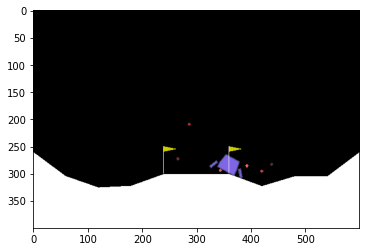

In [ ]:
env.reset()

img = plt.imshow(env.render(mode='rgb_array'))

done = False
i = 0

while not done:
    action = env.action_space.sample()
    observation, reward, done, _ = env.step(action)

    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)

    i += 1
print(i) # 随机走了多少步


## Policy Gradient

現在來搭建一個簡單的 policy network。
我們預設模型的輸入是 8-dim 的 observation，輸出則是離散的四個動作之一：

In [ ]:
class PolicyGradientNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 4)

    def forward(self, state):
        hid = torch.tanh(self.fc1(state))
        hid = torch.tanh(self.fc2(hid))
        return F.softmax(self.fc3(hid), dim=-1)

再來，搭建一個簡單的 agent，並搭配上方的 policy network 來採取行動。
這個 agent 能做到以下幾件事：
- `learn()`：從記下來的 log probabilities 及 rewards 來更新 policy network。
- `sample()`：從 environment 得到 observation 之後，利用 policy network 得出應該採取的行動。
而此函式除了回傳抽樣出來的 action，也會回傳此次抽樣的 log probabilities。

In [ ]:
class PolicyGradientAgent():

    def __init__(self, network):
        self.network = network
        self.optimizer = optim.SGD(self.network.parameters(), lr=0.001)

    def learn(self, log_probs, rewards):
        loss = (-log_probs * rewards).sum()

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def sample(self, state):
        action_prob = self.network(torch.FloatTensor(state))
        action_dist = Categorical(action_prob) #建立概率分布
        action = action_dist.sample()
        log_prob = action_dist.log_prob(action)
        return action.item(), log_prob

最後，建立一個 network 和 agent，就可以開始進行訓練了。

In [ ]:
network = PolicyGradientNetwork()
agent = PolicyGradientAgent(network)

## 訓練 Agent

現在我們開始訓練 agent。
透過讓 agent 和 environment 互動，我們記住每一組對應的 log probabilities 及 reward，並在成功登陸或者不幸墜毀後，回放這些「記憶」來訓練 policy network。

In [ ]:
agent.network.train()  # 訓練前，先確保 network 處在 training 模式
EPISODE_PER_BATCH = 5  # 每蒐集 5 個 episodes 更新一次 agent
NUM_BATCH = 400        # 總共更新 400 次

avg_total_rewards, avg_final_rewards = [], []

prg_bar = tqdm(range(NUM_BATCH))
for batch in prg_bar:

    log_probs, rewards = [], []
    total_rewards, final_rewards = [], []

    # 蒐集訓練資料
    for episode in range(EPISODE_PER_BATCH):
        
        state = env.reset()
        total_reward, total_step = 0, 0

        while True:

            action, log_prob = agent.sample(state)
            next_state, reward, done, _ = env.step(action)

            log_probs.append(log_prob)
            state = next_state
            total_reward += reward
            total_step += 1

            if done:
                final_rewards.append(reward)
                total_rewards.append(total_reward)
                rewards.append(np.full(total_step, total_reward))  # 設定同一個 episode 每個 action 的 reward 都是 total reward
                break

    # 紀錄訓練過程
    avg_total_reward = sum(total_rewards) / len(total_rewards)
    avg_final_reward = sum(final_rewards) / len(final_rewards)
    avg_total_rewards.append(avg_total_reward)
    avg_final_rewards.append(avg_final_reward)
    prg_bar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}")

    # 更新網路
    rewards = np.concatenate(rewards, axis=0)
    rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-9)  # 將 reward 正規標準化
    agent.learn(torch.stack(log_probs), torch.from_numpy(rewards))

  0%|          | 0/400 [00:00<?, ?it/s]

### 訓練結果

訓練過程中，我們持續記下了 `avg_total_reward`，這個數值代表的是：每次更新 policy network 前，我們讓 agent 玩數個回合（episodes），而這些回合的平均 total rewards 為何。
理論上，若是 agent 一直在進步，則所得到的 `avg_total_reward` 也會持續上升，直至 250 上下。
若將其畫出來則結果如下：

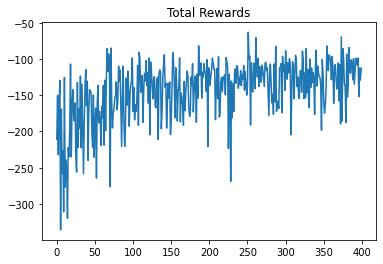

In [ ]:
plt.plot(avg_total_rewards)
plt.title("Total Rewards")
plt.show()

另外，`avg_final_reward` 代表的是多個回合的平均 final rewards，而 final reward 即是 agent 在單一回合中拿到的最後一個 reward。
如果同學們還記得環境給予登月小艇 reward 的方式，便會知道，不論**回合的最後**小艇是不幸墜毀、飛出畫面、或是靜止在地面上，都會受到額外地獎勵或處罰。
也因此，final reward 可被用來觀察 agent 的「著地」是否順利等資訊。

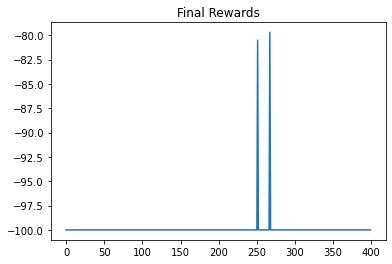

In [ ]:
plt.plot(avg_final_rewards)
plt.title("Final Rewards")
plt.show()

## 測試

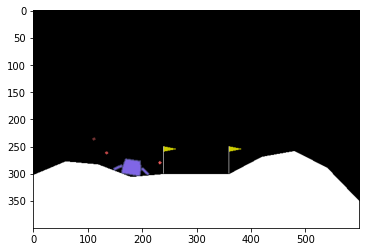

In [ ]:
agent.network.eval()  # 測試前先將 network 切換為 evaluation 模式

state = env.reset()

img = plt.imshow(env.render(mode='rgb_array'))

total_reward = 0

done = False
while not done:
    action, _ = agent.sample(state)
    state, reward, done, _ = env.step(action)

    total_reward += reward

    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [ ]:
print(total_reward)

-107.28819452899141


## 參考資料

以下是一些有用的參考資料。
建議同學們實做前，可以先參考第一則連結的上課影片。
在影片的最後有提到兩個有用的 Tips，這對於本次作業的實做非常有幫助。

- [DRL Lecture 1: Policy Gradient (Review)](https://youtu.be/z95ZYgPgXOY)
- [ML Lecture 23-3: Reinforcement Learning (including Q-learning) start at 30:00](https://youtu.be/2-JNBzCq77c?t=1800)
- [Lecture 7: Policy Gradient, David Silver](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/pg.pdf)


# **Problem 1**
Policy Gradient 方法
1. 請閱讀及跑過範例程式，並試著改進 reward 計算的方式。
2. 請說明你如何改進 reward 的算法，而不同的算法又如何影響訓練結果？


In [ ]:
# 尝试assign suitable credit
network = PolicyGradientNetwork()
agent = PolicyGradientAgent(network)
agent.network.train()  # 訓練前，先確保 network 處在 training 模式
EPISODE_PER_BATCH = 5  # 每蒐集 5 個 episodes 更新一次 agent
NUM_BATCH = 1200 # 總共更新 1200 次
gamma = 0.99 # 衰减系数

avg_total_rewards, avg_final_rewards = [], []

prg_bar = tqdm(range(NUM_BATCH))
for batch in prg_bar:

    log_probs, rewards = [], []
    total_rewards, final_rewards = [], []

    # 蒐集訓練資料
    for episode in range(EPISODE_PER_BATCH):
        
        state = env.reset()
        total_reward, total_step = 0, 0
        ep_rewards = []

        while True:

            action, log_prob = agent.sample(state)
            next_state, reward, done, _ = env.step(action)

            log_probs.append(log_prob)
            state = next_state
            total_reward += reward
            total_step += 1
            ep_rewards.append(reward)

            if done:
                final_rewards.append(reward)
                total_rewards.append(total_reward)
                # rewards.append(np.full(total_step, total_reward))  # 設定同一個 episode 每個 action 的 reward 都是 total reward
                # assign suitable credit
                for i in range(len(ep_rewards)-2, -1, -1):
                    ep_rewards[i] += gamma * ep_rewards[i+1]
                rewards.append(np.array(ep_rewards))
                break

    # 紀錄訓練過程
    avg_total_reward = sum(total_rewards) / len(total_rewards)
    avg_final_reward = sum(final_rewards) / len(final_rewards)
    avg_total_rewards.append(avg_total_reward)
    avg_final_rewards.append(avg_final_reward)
    prg_bar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}")

    # 更新網路
    rewards = np.concatenate(rewards, axis=0)
    rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-9)  # 將 reward 正規標準化
    agent.learn(torch.stack(log_probs), torch.from_numpy(rewards))

  0%|          | 0/1200 [00:00<?, ?it/s]

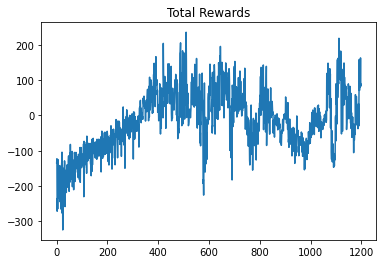

In [ ]:
plt.plot(avg_total_rewards)
plt.title("Total Rewards")
plt.show()

In [ ]:
plt.plot(avg_final_rewards)
plt.title("Final Rewards")
plt.show()

NameError: ignored

In [ ]:
agent.network.eval()  # 測試前先將 network 切換為 evaluation 模式

state = env.reset()

img = plt.imshow(env.render(mode='rgb_array'))

rewards = []
total_reward = 0

done = False
while not done:
    action, _ = agent.sample(state)
    state, reward, done, _ = env.step(action)

    total_reward += reward
    rewards.append(reward)

    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)
print(total_reward)
print(rewards)

NameError: ignored

In [ ]:
# 尝试assign suitable credit和没有归一化（baseline）

network = PolicyGradientNetwork()
agent = PolicyGradientAgent(network)
agent.network.train()  # 訓練前，先確保 network 處在 training 模式
EPISODE_PER_BATCH = 5  # 每蒐集 5 個 episodes 更新一次 agent
NUM_BATCH = 400 # 總共更新 400 次
gamma = 0.99 # 衰减系数

avg_total_rewards, avg_final_rewards = [], []

prg_bar = tqdm(range(NUM_BATCH))
for batch in prg_bar:

    log_probs, rewards = [], []
    total_rewards, final_rewards = [], []

    # 蒐集訓練資料
    for episode in range(EPISODE_PER_BATCH):
        
        state = env.reset()
        total_reward, total_step = 0, 0
        ep_rewards = []

        while True:

            action, log_prob = agent.sample(state)
            next_state, reward, done, _ = env.step(action)

            log_probs.append(log_prob)
            state = next_state
            total_reward += reward
            total_step += 1
            ep_rewards.append(reward)

            if done:
                final_rewards.append(reward)
                total_rewards.append(total_reward)
                # rewards.append(np.full(total_step, total_reward))  # 設定同一個 episode 每個 action 的 reward 都是 total reward
                # assign suitable credit
                for i in range(len(ep_rewards)-2, -1, -1):
                    ep_rewards[i] += gamma * ep_rewards[i+1]
                rewards.append(np.array(ep_rewards))
                break

    # 紀錄訓練過程
    avg_total_reward = sum(total_rewards) / len(total_rewards)
    avg_final_reward = sum(final_rewards) / len(final_rewards)
    avg_total_rewards.append(avg_total_reward)
    avg_final_rewards.append(avg_final_reward)
    prg_bar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}")

    # 更新網路
    rewards = np.concatenate(rewards, axis=0)
    # rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-9)  # 將 reward 正規標準化
    agent.learn(torch.stack(log_probs), torch.from_numpy(rewards))

  0%|          | 0/400 [00:00<?, ?it/s]

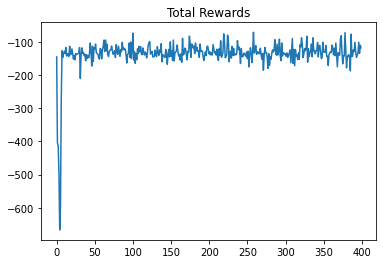

In [ ]:
plt.plot(avg_total_rewards)
plt.title("Total Rewards")
plt.show()

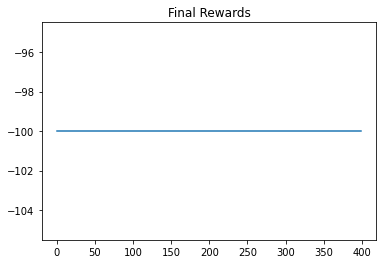

In [ ]:
plt.plot(avg_final_rewards)
plt.title("Final Rewards")
plt.show()

使用了assign suitable credit之前，飞行器大部分时间都是直接坠毁，而且使用了很多主火箭喷射，也就是在天上乱飞了很久，所以total reward都是很小，final reward直接就是-100，少部分有几个是-80上下，应该是最后两只脚着地+20（虽然也坠毁了），只有极少数碰运气可能落到两个旗子之间得了+100，使得total reward在-50左右。

使用了assign suitable credit之后，明显效果好了很多，total reward和final reward都有正数出现了，说明飞行器逐渐学会了平稳降落和落到旗子中间。而且发现400个迭代还没有收敛，训练1200轮差不多了，马马虎虎，等下再用actor-critor方法优化一下。

设计baseline是非常重要的，原始代码中已经通过归一化引入了baseline，我试了一下去掉归一化，在没有baseline的情况下，学习效果非常的糟糕，total reward基本在-100上下。我的猜想是，没有归一化之前，几乎每个log_prob对应的total reward都是负数，飞行器永远不知道平稳落地会得到100分（ppt中提到这个问题，因为采样有限），而在空中一直飞一直消耗燃料就会扣分，所以干脆不怎么飞，开局就直接坠机，所以final reward总是-100。只能说，ai在问题中学会了“躺平”，年轻人为什么不想努力，还是因为不合理的奖罚机制啊！

# **Problem 2**
 試著修改與比較至少三項超參數（神經網路大小、一個 batch 中的回合數等），並說明你觀察到什麼。

调整超参数是作者最讨厌的一件事，希望大家把精力都放在问题，数据和模型上来，所以这里实验没有去做，而是摘取了网络上的一些超参数对drl的影响的结论，以供大家参考。

来源：https://bbs.cvmart.net/articles/4146
* 神经网络大小

  过大、过深的神经网络不适合DRL，因为：
    * 深度学习可以在整个训练结束后再使用训练好的模型。而强化学习需要在几秒钟的训练后马上使用刚训好的模型。这导致DRL只能用比较浅的网络来保证快速拟合（10层以下)
    * 并且强化学习的训练数据不如有监督学习那么稳定，无法划分出训练集测试集去避免过拟合，因此DRL也不能用太宽的网络（超过1024），避免参数过度冗余导致过拟合。
* dropout、批归一化
  
  他们在DL中得到广泛地使用，可惜不适合DRL。如果非要用，那么也要选择非常小的 dropout rate（0\~0.2），而且要注意在使用的时候关掉dropout。
* 记忆容量
  
  经验回放缓存 experimence replay buffer 的最大容量 max capacity，如果超过容量限制，它就会删掉最早的记忆。在简单的任务中（训练步数小于1e6），对于探索能力强的DRL算法，通常在缓存被放满前就训练到收敛了，不需要删除任何记忆。然而，过大的记忆也会拖慢训练速度，我一般会先从默认值 2 ** 17 \~ 2 ** 20 开始尝试，如果环境的随机因素大，我会同步增加记忆容量 与 batch size、网络更新次数，直到逼近服务器的内存、显存上限（放在显存训练更快）
* 批次大小、更新次数
  
  一般我会选择与网络宽度相同、或略大的批次大小batch size。我一般从128、256 开始尝试这些2的N次方。在off-policy中，每往Replay 更新几个数据，就对应地更新几次网络，这样做简单，但效果一般。（深度学习里）更优秀的更新方法是：根据Replay中数据数量，成比例地修改更新次数。Don't Decay the Learning Rate, Increase the Batch Size. ICLR. 2018 。，经过验证，DRL也适用。我根据Replay中数据个数来调整 batch size 和 update times：（**有点怀疑，这么振荡还可以用small batch嘛**）
```python
replay_max = 'the maximum capacity of replay buffer'
replay_len = len(ReplayBuffer)
k = 1 + replay_len / replay_max
batch_size   = int(k * basic_batch_size)
update_times = int(k * basic_update_times)
for _ in range(update_times):
    data = ReplayBuffer.random_sample(batch_size)
```
* 折扣因子

  discount factor（或者叫 discount-rate parameter），gamma 。这个值很容易确定，请回答“你希望你的智能体每做出一步，至少需要考虑接下来多少步的reward？”如果是t 步：
```python
gamma ** t = 0.1  # 0.1 对于当前这一步来说，t步后的reward的权重
gamma = 0.1 ** (1/t)
# 0.93  ~= 0.1 ** (1/32)
# 0.98  ~= 0.1 ** (1/128)
# 0.99  ~= 0.1 ** (1/256) 
# 0.995 ~= 0.1 ** (1/512)
# 可以看到 0.93, 0.98, 0.99, 0.995 的gamma值
# 分别对应   32,  128,  256,   512 的步数
```
gamma绝对不能选择1.0。尽管在入门DRl任务选择gamma=0.1 甚至能训练得更快，但是gamma等于1 有“让Q值无限大”的风险。gamma值一般选择0.99即可，在某些任务上需要调整。

更多可以参考原网页



# **Problem 3**
Actor-Critic 方法

請同學們從 REINFORCE with baseline、Q Actor-Critic、A2C 等眾多方法中擇一實作。
請說明你的實做與前者（Policy Gradient）的差異。


## D3QN
  
  因为actor-critic方法要用到critic方法，所以我们先实现一个D3QN(Dueling Double Deep Q Networks)，同时使用了replay buffer和exploration机制，来测试一下效果。


### Replay Buffer


In [ ]:
# 定义训练的data
Data = namedtuple('Data',('state', 'action', 'next_state', 'reward'))
class ReplayMemory(object):
    def __init__(self, capacity):
        # deque就是双头链表，可以快速插入删除，满了以后再插入会自动删除最早的元素
        self.memory = deque([], maxlen=capacity)

    def store(self, *args):
        """Store a Data"""
        self.memory.append(Data(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

### Model

In [ ]:
class D3QN(nn.Module):

    def __init__(self, inputsize, outputsize):
        super(D3QN, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(inputsize, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, outputsize)
        )
        # # dueling dqn
        # self.layer2v = nn.Sequential(
        #     nn.Linear(16, 8),
        #     # nn.ReLU(),
        #     nn.Linear(8, 1)
        # )
        # self.layer2a = nn.Sequential(
        #     nn.Linear(16, 16),
        #     # nn.ReLU(),
        #     nn.Linear(16, outputsize)
        # )

    def forward(self, x):
        x = self.linear_relu_stack(x)
        # # dueling dqn
        # v = self.layer2v(x)
        # a = self.layer2a(x)
        # a = a - torch.mean(a, axis=1, keepdim=True)
        # q = a+v
        return x

### Train Function


In [ ]:
def train():
    if len(memory) < BATCH_SIZE:
        return
    datas = memory.sample(BATCH_SIZE) # BATCH_SIZE * data(namedtuple)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Datas
    # to Datas of batch-arrays.
    batch = Data(*zip(*datas)) # a data(namedtuple) which every elem is a tuple of 2 dim tensor(expect reward)

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state) # BATCH_SIZE * 8 tensor
    action_batch = torch.cat(batch.action) # BATCH_SIZE * 1 tensor
    reward_batch = torch.cat(batch.reward) # # BATCH_SIZE tensor

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}, argmax(a)_Q(s_{t+1})) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the target_net and policy_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE)
    
    with torch.no_grad():
        # double dqn
        # policy_next_state_values = policy_net(non_final_next_states)
        # target_next_state_values = target_net(non_final_next_states)
        # next_state_values[non_final_mask] = target_next_state_values.gather(1, torch.max(policy_next_state_values, 1)[1].unsqueeze(1)).squeeze(1)
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    expected_state_action_values = expected_state_action_values.float()
    # print(state_action_values.dtype)
    # print(expected_state_action_values.dtype)

    # Compute Huber loss
    # criterion = nn.SmoothL1Loss()
    criterion = nn.MSELoss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # 网络很浅，所以不采用梯度截断
    # for param in policy_net.parameters():
    #     param.grad.data.clamp_(-1, 1)
    optimizer.step()

### Train Loop

In [ ]:
# hyperparameters
num_episodes = 1000
BATCH_SIZE = 64
GAMMA = 0.99
TARGET_UPDATE = 300 # target networks每多少步更新一次
REPLAY_CAPACITY = 50000
n_actions = env.action_space.n
n_states = env.observation_space.shape[0]
policy_net = D3QN(n_states, n_actions)
policy_net.train()
target_net = D3QN(n_states, n_actions)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.SGD(policy_net.parameters(), lr=0.001)
memory = ReplayMemory(REPLAY_CAPACITY)

# utilities
import math
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
steps_done = 0
def select_action(state):# epsilon greedy policy
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], dtype=torch.long)

# trian loop
from itertools import count

total_rewards, final_rewards = [], []   
prg_bar = tqdm(range(num_episodes))
for i_episode in prg_bar:
    # Initialize the environment and state
    state = env.reset()
    state = torch.FloatTensor([state])
    total_reward = 0
    for t in range(2000):# 每轮规定最多走2000步
        # Select and perform an action
        action = select_action(state)
        next_state, reward, done, _ = env.step(action.item())
        # 防止一开始飞行器尝试不到平稳降落得100分
        if reward==-100:
            reward = -3
        total_reward += reward
        reward = torch.tensor([reward])
        next_state = torch.tensor([next_state])
        # Observe new state
        if done:
            next_state = None

        # Store the transition in memory
        memory.store(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        train()

        if done:
            total_rewards.append(total_reward)
            final_rewards.append(reward.item())
            break
        
        # Update the target network, copying all weights and biases in DQN
        if steps_done % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())

  0%|          | 0/1000 [00:00<?, ?it/s]

### Test

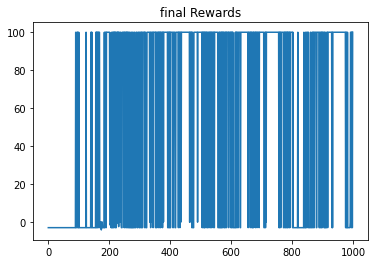

In [ ]:
plt.plot(final_rewards)
plt.title("final Rewards")
plt.show()

In [ ]:
policy_net.eval()  # 測試前先將 network 切換為 evaluation 模式

total_rewards = []
for i in range(200):
    state = env.reset()
    # img = plt.imshow(env.render(mode='rgb_array'))
    total_reward = 0
    done = False
    while not done:
        action = select_action(torch.FloatTensor([state]))
        state, reward, done, _ = env.step(action.item())

        total_reward += reward

        # img.set_data(env.render(mode='rgb_array'))
        # display.display(plt.gcf())
        # display.clear_output(wait=True)
    # print(total_reward)
    total_rewards.append(total_reward)
print(np.mean(total_rewards))# 200次的平均成绩

254.2907635931527


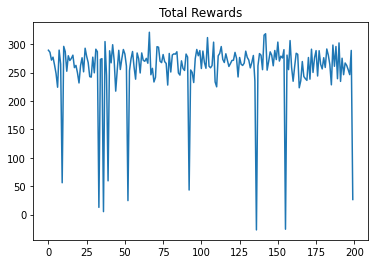

In [ ]:
plt.plot(total_rewards)
plt.title("Total Rewards")
plt.show()

整体来说D3QN还是非常给力（其实只用了DQN，不知道为什么double DQN效果比DQN差好多，用dueling DQN直接崩掉，但是也是一路方法啦。真的试了好久但是就是train不出来，我哭死），训练效果比policy-based方法好的多，每个episode的mean total reward达到了250左右，按照目标达到200就成功了，网上有更多牛人跑到了280左右，作者再次就不再细究了，直接去写a2c方法完成作业。

要注意的是，在训练过程中，为了防止模型一直不知道静止降落可以拿100分，只知道坠毁，所以把坠毁的reward改成了-3。

## REINFORCE with baseline
参考：https://iamarookie.blog.csdn.net/article/details/120426499?spm=1001.2101.3001.6650.5&utm_medium=distribute.pc_relevant.none-task-blog-2%7Edefault%7EBlogCommendFromBaidu%7ERate-5.pc_relevant_default&depth_1-utm_source=distribute.pc_relevant.none-task-blog-2%7Edefault%7EBlogCommendFromBaidu%7ERate-5.pc_relevant_default&utm_relevant_index=10

### Replay Buffer

In [1]:
class Memory:
    def __init__(self):
        """初始化"""
        self.actions = []  # 行动(共4种)
        self.states = []  # 状态, 由8个数字组成
        self.logprobs = []  # 概率
        self.rewards = []  # 奖励
        self.is_terminals = []  # 游戏是否结束

    def clear_memory(self):
        """清除memory"""
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]

### Model
state比较简单，所以没有两者共用参数

In [5]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, n_latent_var):
        super(ActorCritic, self).__init__()

        # 行动
        self.action_layer = nn.Sequential(
            # [b, 8] => [b, 64]
            nn.Linear(state_dim, n_latent_var),
            nn.Tanh(),  # 激活

            # [b, 64] => [b, 64]
            nn.Linear(n_latent_var, n_latent_var),
            nn.Tanh(),  # 激活

            # [b, 64] => [b, 4]
            nn.Linear(n_latent_var, action_dim),
            nn.Softmax(dim=-1)
        )

        # 评判
        self.value_layer = nn.Sequential(
            # [b, 8] => [8, 64]
            nn.Linear(state_dim, n_latent_var),
            nn.Tanh(),  # 激活

            # [b, 64] => [b, 64]
            nn.Linear(n_latent_var, n_latent_var),
            nn.Tanh(),

            # [b, 64] => [b, 1]
            nn.Linear(n_latent_var, 1)
        )

    def forward(self):
        """前向传播, 由act替代"""

        raise NotImplementedError

    def act(self, state, memory):
        """计算行动"""

        # 转成张量
        state = torch.from_numpy(state).float()

        # 计算4个方向概率
        action_probs = self.action_layer(state)

        # 通过最大概率计算最终行动方向
        dist = Categorical(action_probs)
        action = dist.sample()

        # 存入memory
        memory.states.append(state)
        memory.actions.append(action)
        memory.logprobs.append(dist.log_prob(action))

        # 返回行动
        return action.item()

    def evaluate(self, state, action):
        """
        评估
        :param state: 状态, 2000个一组, 形状为 [2000, 8]
        :param action: 行动, 2000个一组, 形状为 [2000]
        :return:
        """

        # 计算行动概率
        action_probs = self.action_layer(state)
        dist = Categorical(action_probs)  # 转换成类别分布

        # 计算概率密度, log(概率)
        action_logprobs = dist.log_prob(action)

        # 计算熵
        dist_entropy = dist.entropy()

        # 评判
        state_value = self.value_layer(state)
        state_value = torch.squeeze(state_value)  # [2000, 1] => [2000]

        # 返回行动概率密度, 评判值, 行动概率熵
        return action_logprobs, state_value, dist_entropy

### PPO


In [15]:
class PPO:
    def __init__(self, state_dim, action_dim, n_latent_var, lr, betas, gamma, K_epochs, eps_clip):
        self.lr = lr  # 学习率
        self.betas = betas  # betas
        self.gamma = gamma  # gamma
        self.eps_clip = eps_clip  # 裁剪, 限制值范围
        self.K_epochs = K_epochs  # 迭代次数

        # 初始化policy
        self.policy = ActorCritic(state_dim, action_dim, n_latent_var)
        self.policy_old = ActorCritic(state_dim, action_dim, n_latent_var)
        self.policy_old.load_state_dict(self.policy.state_dict())

        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr, betas=betas)  # 优化器
        self.MseLoss = nn.MSELoss()  # 损失函数

    def update(self, memory):
        """更新梯度"""

        # 蒙特卡罗预测状态回报
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(memory.rewards), reversed(memory.is_terminals)):
            # 回合结束
            if is_terminal:
                discounted_reward = 0

            # 更新削减奖励(当前状态奖励 + 0.99*上一状态奖励
            discounted_reward = reward + (self.gamma * discounted_reward)

            # 首插入
            rewards.insert(0, discounted_reward)

        # 标准化奖励
        rewards = torch.tensor(rewards, dtype=torch.float32)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-5)

        # 张量转换
        old_states = torch.stack(memory.states).detach()
        old_actions = torch.stack(memory.actions).detach()
        old_logprobs = torch.stack(memory.logprobs).detach()

        # 迭代优化 K 次:
        for _ in range(self.K_epochs):
            # 评估
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)

            # 计算ratios
            ratios = torch.exp(logprobs - old_logprobs.detach())

            # 计算损失
            advantages = rewards - state_values.detach()
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1 - self.eps_clip, 1 + self.eps_clip) * advantages
            # 为何要加dist_entropy这一项呢？我们想要在 agent 与 environment 进行互动的过程中，平衡 探索和利用，
            # 我们想去以一定的几率来尝试其他的 action，从而不至于采样得到的样本太过于集中。所以，引入这个 entropy，来使得输出的分布，能够更加的平衡。
            loss = -torch.min(surr1, surr2) + 0.5 * self.MseLoss(state_values, rewards) - 0.01 * dist_entropy

            # 梯度清零
            self.optimizer.zero_grad()

            # 反向传播
            loss.mean().backward()

            # 更新梯度
            self.optimizer.step()

        # 将新的权重赋值给旧policy
        self.policy_old.load_state_dict(self.policy.state_dict())

### Train Loop

In [16]:
# hyperparameters
state_dim = 8  # 状态维度
action_dim = 4  # 行动维度
solved_reward = 230  # 停止循环条件 (奖励 > 230)
log_interval = 100  # print avg reward in the interval
max_episodes = 50000  # 最大迭代次数
max_timesteps = 2000  # 最大单次游戏步数
n_latent_var = 64  # 全连接隐层维度
update_timestep = 2000  # 每2000步policy更新一次
lr = 0.002  # 学习率
betas = (0.9, 0.999)  # betas
gamma = 0.99  # gamma
K_epochs = 4  # policy迭代更新次数
eps_clip = 0.2  # PPO 限幅



total_rewards, final_rewards = [], []
total_rewards_window = deque([], maxlen=log_interval)
memory = Memory()
ppo = PPO(state_dim, action_dim, n_latent_var, lr, betas, gamma, K_epochs, eps_clip)
timestep = 0

# 训练
prg_bar = tqdm(range(1, max_episodes+1))
for i_episode in prg_bar:
    # 环境初始化
    state = env.reset()  # 初始化（重新玩）
    total_reward = 0

    # 迭代
    for t in range(max_timesteps):
        timestep += 1

        # 用旧policy得到行动
        action = ppo.policy_old.act(state, memory)

        # 行动
        state, reward, done, _ = env.step(action)  # 得到（新的状态，奖励，是否终止，额外的调试信息）

        # 更新memory(奖励/游戏是否结束)
        memory.rewards.append(reward)
        memory.is_terminals.append(done)

        # 更新梯度
        if timestep % update_timestep == 0:
            ppo.update(memory)
            
            # memory清零
            memory.clear_memory()

            # 累计步数清零
            timestep = 0
        
        # 累加
        total_reward += reward

        # 如果游戏结束, 退出
        if done:
            total_rewards.append(total_reward)
            total_rewards_window.append(total_reward)
            final_rewards.append(reward)
            break
        

    # 如果达到要求(230分), 退出循环
    if np.mean(total_rewards_window) >= solved_reward:
        print("########## Solved! ##########")

        # # 保存模型
        # torch.save(ppo.policy.state_dict(), './PPO_{}.pth'.format(env_name))

        # 退出循环
        break

    # 输出log, 每200次迭代
    if i_episode % log_interval == 0:
            
        # 输出200次迭代平均时长/收益
        print('Episode {} \t average_reward: {}'.format(i_episode, np.mean(total_rewards_window)))

  0%|          | 0/50000 [00:00<?, ?it/s]

Episode 100 	 average_reward: -162.34080338687784
Episode 200 	 average_reward: -129.43977099555624
Episode 300 	 average_reward: -133.26005363409357
Episode 400 	 average_reward: -73.89905456441804
Episode 500 	 average_reward: -47.80775806667395
Episode 600 	 average_reward: 23.716706358275122
Episode 700 	 average_reward: 81.74906030877581
Episode 800 	 average_reward: 68.34978036159563
Episode 900 	 average_reward: 98.78698862594179
Episode 1000 	 average_reward: 47.09617060334069
Episode 1100 	 average_reward: 97.06485224505457
Episode 1200 	 average_reward: 118.2956907616078
Episode 1300 	 average_reward: 102.4080090139284
Episode 1400 	 average_reward: 111.45218271783992
Episode 1500 	 average_reward: 134.44334866104694
Episode 1600 	 average_reward: 119.99197728817718
Episode 1700 	 average_reward: 73.29422111445474
Episode 1800 	 average_reward: 85.43582877014636
Episode 1900 	 average_reward: 83.07247051115043
Episode 2000 	 average_reward: 108.43675251616287
Episode 2100 	 a

### Test

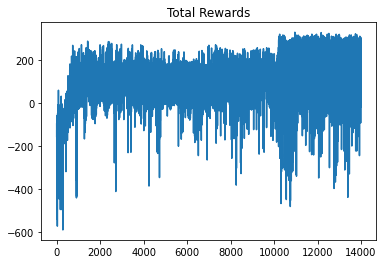

In [17]:
plt.plot(total_rewards)
plt.title("Total Rewards")
plt.show()

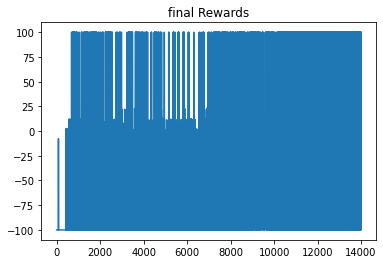

In [18]:
plt.plot(final_rewards)
plt.title("final Rewards")
plt.show()

AC方法也不负众望，train到均分230啦，之所以没train更高，是因为不想train了哈哈，因为真的要train太久了，相信只要有足够的iterations，AC方法也可以达到280分。

写完作业下班啦。